In [ ]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
from keras.preprocessing import image
import keras.utils as image

In [ ]:
! unzip /content/batch_dataset.zip

Archive:  /content/batch_dataset.zip
   creating: batch_dataset/
   creating: batch_dataset/color/
  inflating: batch_dataset/color/0.jpg  
  inflating: batch_dataset/color/1.jpg  
  inflating: batch_dataset/color/10.jpg  
  inflating: batch_dataset/color/100.jpg  
  inflating: batch_dataset/color/101.jpg  
  inflating: batch_dataset/color/102.jpg  
  inflating: batch_dataset/color/103.jpg  
  inflating: batch_dataset/color/104.jpg  
  inflating: batch_dataset/color/105.jpg  
  inflating: batch_dataset/color/106.jpg  
  inflating: batch_dataset/color/107.jpg  
  inflating: batch_dataset/color/108.jpg  
  inflating: batch_dataset/color/109.jpg  
  inflating: batch_dataset/color/11.jpg  
  inflating: batch_dataset/color/110.jpg  
  inflating: batch_dataset/color/111.jpg  
  inflating: batch_dataset/color/112.jpg  
  inflating: batch_dataset/color/113.jpg  
  inflating: batch_dataset/color/114.jpg  
  inflating: batch_dataset/color/115.jpg  
  inflating: batch_dataset/color/116.jpg  
  in

In [ ]:
gray_images = sorted(os.listdir('/content/batch_dataset/gray'))
color_images = sorted(os.listdir('/content/batch_dataset/color'))

In [ ]:
gray_image = []
for im in gray_images:
    img = image.load_img("/content/batch_dataset/gray/"+ im, target_size=(160,160), color_mode= 'rgb')
    img = image.img_to_array(img)
    img = img/255
    gray_image.append(img)
gray_image = np.array(gray_image)

In [ ]:
color_image = []
for im in color_images:
    img = image.load_img("/content/batch_dataset/color/"+ im, target_size=(160,160), color_mode= 'rgb')
    img = image.img_to_array(img)
    img = img/255
    color_image.append(img)
color_image = np.array(color_image)

In [ ]:
print(gray_image.shape)
print(color_image.shape)


(301, 160, 160, 3)
(301, 160, 160, 3)


In [ ]:
def plot_images(color,grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)

    plt.show()

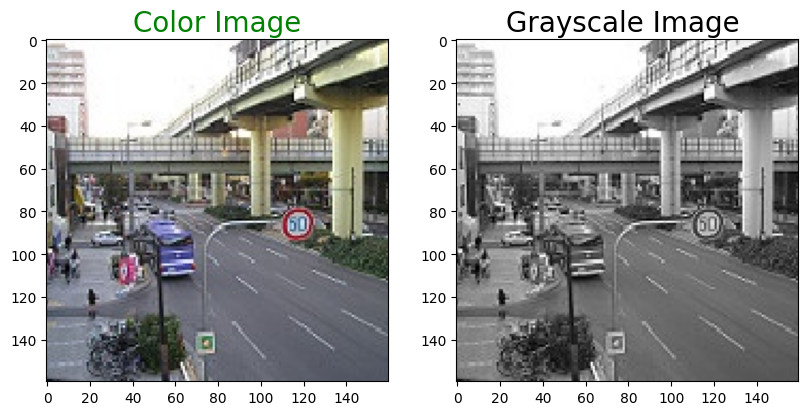

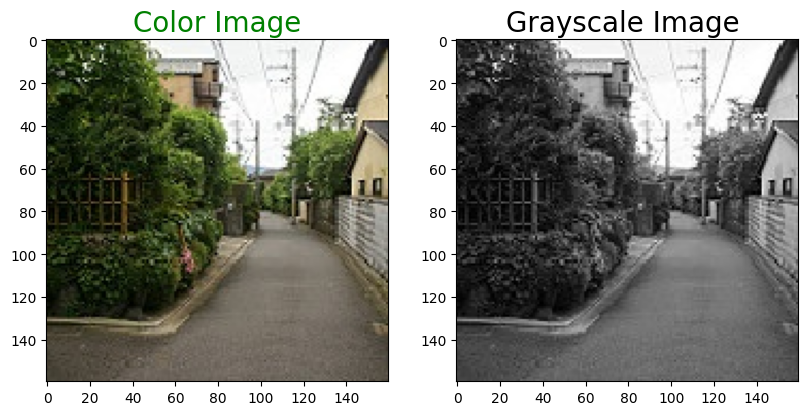

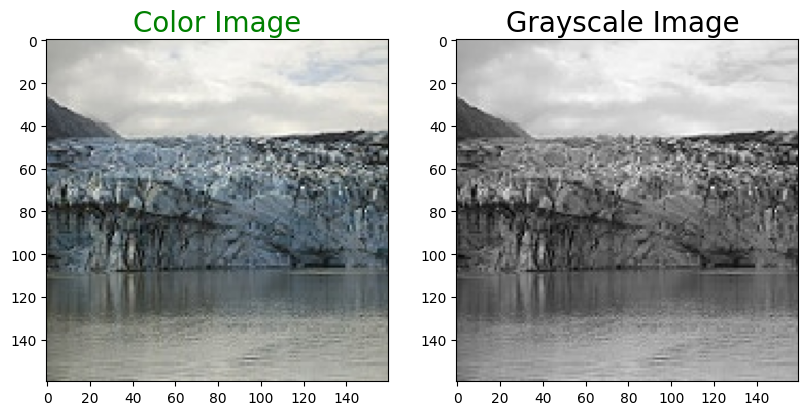

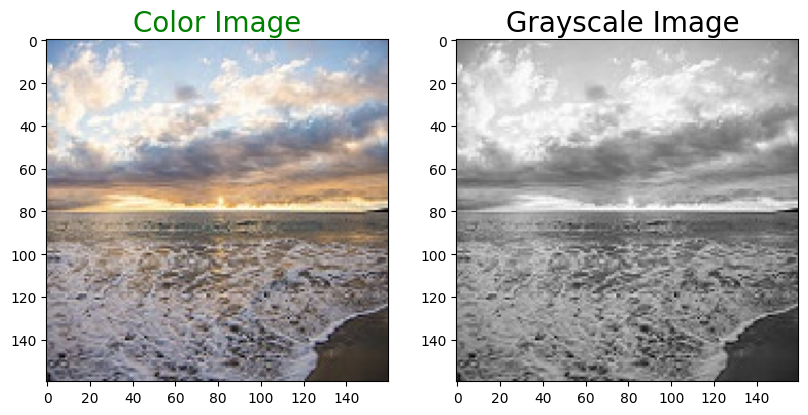

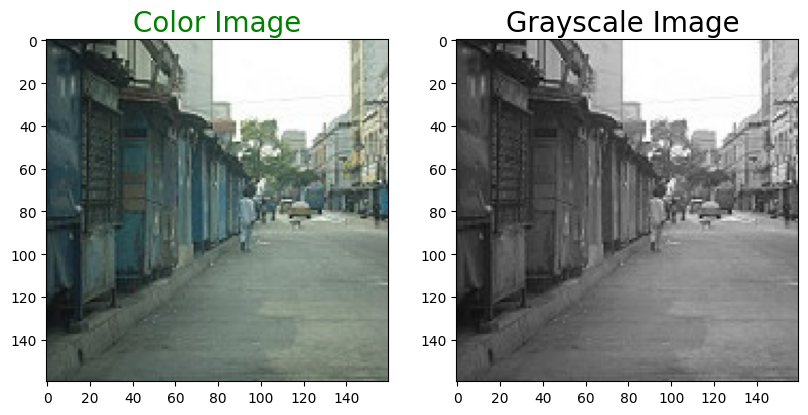

In [ ]:
for i in range(3,8):
     plot_images(color_image[i],gray_image[i])

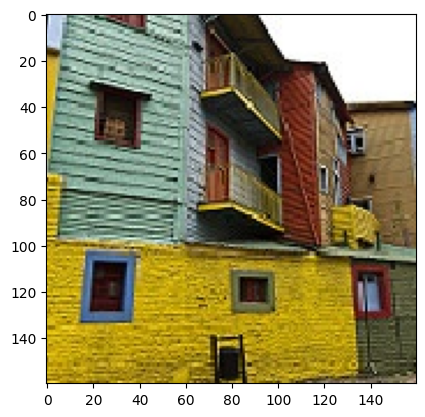

In [ ]:
plt.imshow(color_image[1])


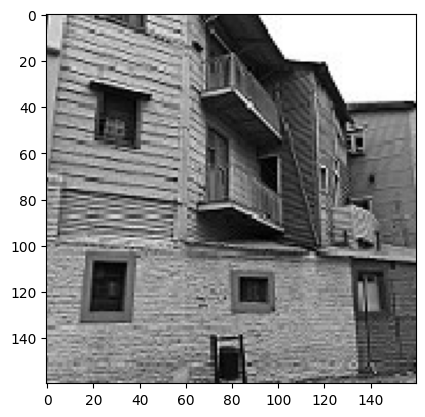

In [ ]:
plt.imshow(gray_image[1])

In [ ]:
gray_train= gray_image[0:290]
gray_test= gray_image[290:]
color_train= color_image[0:290]
color_test= color_image[290:]

In [ ]:
from keras import layers
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = True):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

In [ ]:
def model():
    inputs = layers.Input(shape= [160,160,3])
    d1 = down(256,(3,3),True)(inputs)
    d2 = down(256,(3,3),True)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(256,(3,3),True)(d3)
    d5 = down(256,(3,3),True)(d4)
    #upsampling

    u1 = up(128,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(128,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)
model = model()
model.summary()

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss = 'MSE',
              metrics = ['acc'])

model.fit(gray_train, color_train, epochs = 20 ,batch_size = 64 ,shuffle=True, validation_data=(gray_test, color_test))

In [ ]:
model.evaluate(gray_test,color_test)

1/1 [==============================] - 1s 645ms/step


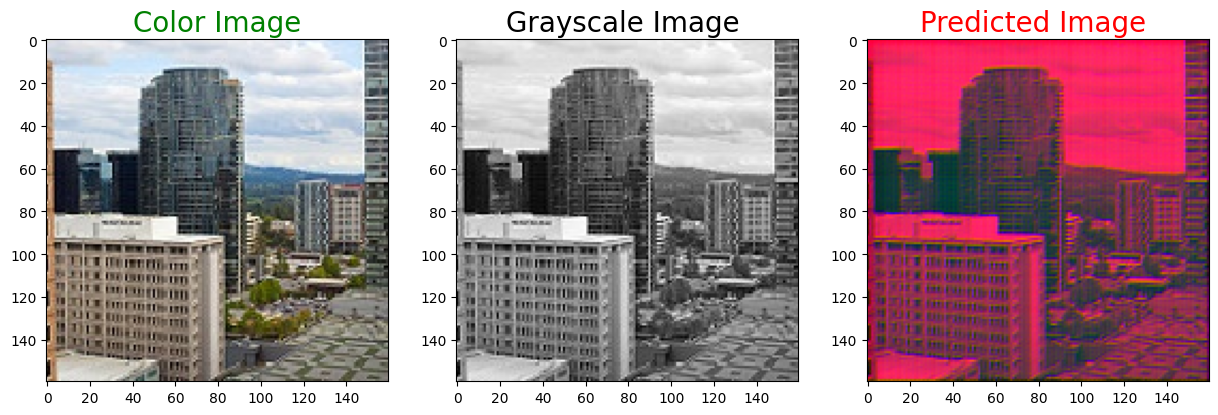

1/1 [==============================] - 0s 31ms/step


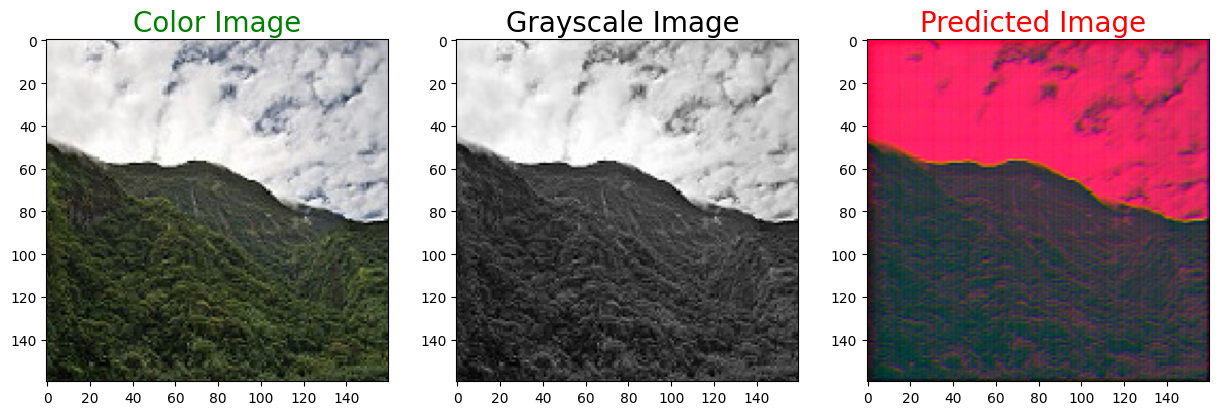

1/1 [==============================] - 0s 29ms/step


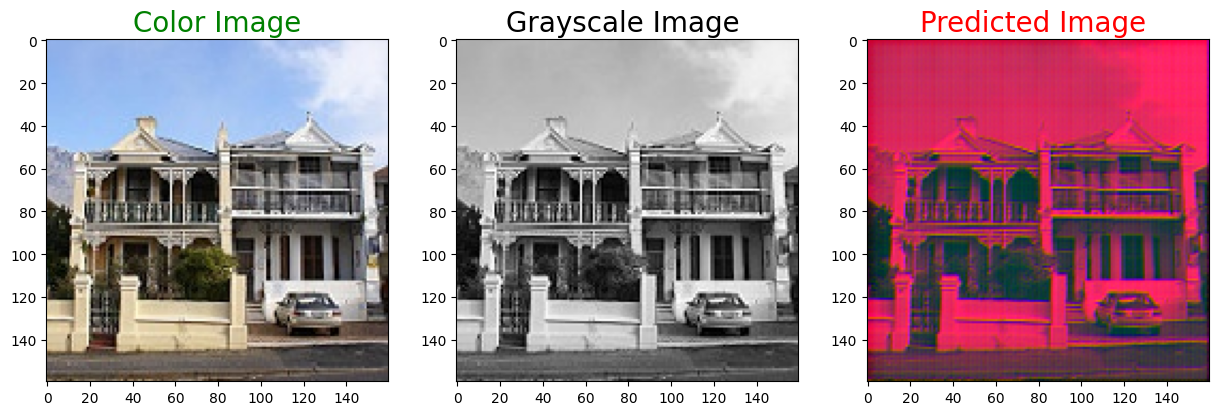

1/1 [==============================] - 0s 30ms/step


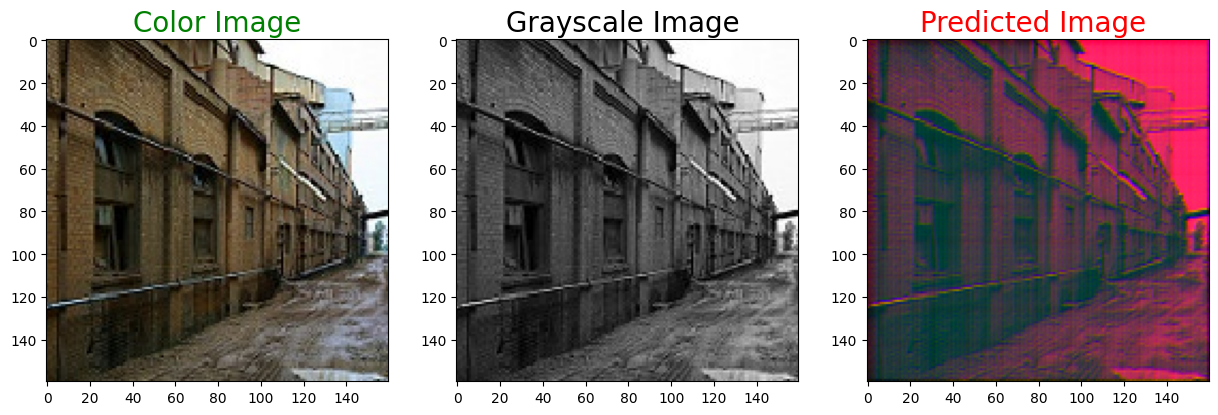

In [ ]:
# defining function to plot images pair
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)

    plt.show()

for i in range(6,10):
    predicted = np.clip(model.predict(gray_test[i].reshape(1,160, 160,3)),0.0,1.0).reshape(160, 160,3)
    plot_images(color_test[i],gray_test[i],predicted)